# 自建GPT训练流程 - Part 4: DPO偏好对齐

## 概述

本notebook演示如何使用**DPO (Direct Preference Optimization)** 对SFT模型进行偏好对齐，让模型学会生成人类更喜欢的回答。

**设备建议：** CPU 可跑（训练时间更长），GPU 可加速。

### DPO vs RLHF

```
传统RLHF:
  SFT模型 → 训练Reward Model → PPO强化学习 → 对齐模型
  (复杂、不稳定、计算量大)

DPO:
  SFT模型 → 直接用偏好数据优化 → 对齐模型
  (简单、稳定、高效)
```

### DPO的核心思想

给定同一个prompt的两个回答：
- **Chosen (好回答)**: 人类更喜欢的回答
- **Rejected (差回答)**: 人类不喜欢的回答

DPO目标：增加chosen的概率，降低rejected的概率

```
Loss = -log(σ(β * (log π(chosen) - log π_ref(chosen)) 
              - β * (log π(rejected) - log π_ref(rejected))))
```

其中π是当前模型，π_ref是参考模型(通常是SFT模型)，β控制偏离程度

## 环境设置

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import os
import sys
import copy

# 兼容从项目根目录或本目录运行
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), "..")) if os.path.basename(os.getcwd()) == "Custom_GPT_Training" else os.getcwd()
CUSTOM_GPT_DIR = os.path.join(PROJECT_ROOT, "Custom_GPT_Training")
sys.path.insert(0, CUSTOM_GPT_DIR)

from custom_gpt import (
    CustomGPT, 
    GPTConfig, 
    SimpleTokenizer,
    count_parameters
)

# 设备选择
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"使用设备: {device}")

# 可复现性
torch.manual_seed(42)
np.random.seed(42)

使用设备: cuda


## Part 1：DPO 偏好数据

本路线聚焦“短知识问答”，偏好对中 chosen 偏好结构化“要点”风格（定义+作用），rejected 为非结构化回答。


In [14]:
# DPO偏好数据：从 data/ 读取（训练/验证/测试拆分）
import json
from pathlib import Path

def resolve_data_dir():
    candidates = [Path.cwd(), Path.cwd().parent]
    for base in candidates:
        data_dir = base / "data"
        if data_dir.exists():
            return str(data_dir)
    return os.path.join(os.getcwd(), "data")

DATA_DIR = resolve_data_dir()


def load_jsonl(path):
    with open(path, "r", encoding="utf-8-sig") as f:
        return [json.loads(line) for line in f if line.strip()]

DPO_TRAIN = load_jsonl(os.path.join(DATA_DIR, "custom_dpo_train.jsonl"))
DPO_VAL = load_jsonl(os.path.join(DATA_DIR, "custom_dpo_val.jsonl"))
DPO_TEST = load_jsonl(os.path.join(DATA_DIR, "custom_dpo_test.jsonl"))

print(f"DPO训练集: {len(DPO_TRAIN)} 条 | 验证集: {len(DPO_VAL)} 条 | 测试集: {len(DPO_TEST)} 条")
print(f"示例: {DPO_TRAIN[0]}")


DPO训练集: 8000 条 | 验证集: 1000 条 | 测试集: 1000 条
示例: {'prompt': '用简洁语言介绍Temperature', 'chosen': '要点：1) 定义：控制采样随机性的参数 2) 作用：数值越高越发散。', 'rejected': 'Temperature是控制采样随机性的参数，主要用于数值越高越发散。', 'category': '知识问答'}


## Part 2: DPO数据集

In [15]:
# ChatML格式化器（复用）
class ChatMLFormatter:
    SYSTEM_PROMPT = "你是一个有帮助的AI助手。"
    SYSTEM_TOKEN = "<|system|>"
    USER_TOKEN = "<|user|>"
    ASSISTANT_TOKEN = "<|assistant|>"
    END_TOKEN = "<|endoftext|>"
    
    @classmethod
    def format(cls, instruction, response, include_system=True):
        parts = []
        if include_system:
            parts.append(f"{cls.SYSTEM_TOKEN}{cls.SYSTEM_PROMPT}{cls.END_TOKEN}")
        parts.append(f"{cls.USER_TOKEN}{instruction}{cls.END_TOKEN}")
        parts.append(f"{cls.ASSISTANT_TOKEN}{response}{cls.END_TOKEN}")
        return "\n".join(parts)
    
    @classmethod
    def format_prompt_only(cls, instruction, include_system=True):
        parts = []
        if include_system:
            parts.append(f"{cls.SYSTEM_TOKEN}{cls.SYSTEM_PROMPT}{cls.END_TOKEN}")
        parts.append(f"{cls.USER_TOKEN}{instruction}{cls.END_TOKEN}")
        parts.append(f"{cls.ASSISTANT_TOKEN}")
        return "\n".join(parts)

In [16]:
class DPODataset(Dataset):
    """
    DPO数据集
    
    返回:
    - chosen_ids: 好回答的完整token序列
    - rejected_ids: 差回答的完整token序列
    - prompt_length: prompt部分的长度（用于只计算response部分的概率）
    """
    
    def __init__(self, data, tokenizer, max_length=256):
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.data = data
        
        # 字符级分词器会直接处理ChatML标记；仅在word模式时扩充词表
        if getattr(tokenizer, "mode", "char") != "char" and hasattr(tokenizer, "add_special_token"):
            special_tokens = [
                ChatMLFormatter.SYSTEM_TOKEN,
                ChatMLFormatter.USER_TOKEN,
                ChatMLFormatter.ASSISTANT_TOKEN,
                ChatMLFormatter.END_TOKEN
            ]
            for token in special_tokens:
                if token not in tokenizer.token_to_id:
                    tokenizer.add_special_token(token)
        
        print(f"DPO数据集: {len(data)} 条")
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        item = self.data[idx]
        
        # 格式化
        chosen_text = ChatMLFormatter.format(item['prompt'], item['chosen'])
        rejected_text = ChatMLFormatter.format(item['prompt'], item['rejected'])
        prompt_text = ChatMLFormatter.format_prompt_only(item['prompt'])
        
        # 编码
        chosen_ids = self.tokenizer.encode(chosen_text, add_bos=True, add_eos=False)
        rejected_ids = self.tokenizer.encode(rejected_text, add_bos=True, add_eos=False)
        prompt_ids = self.tokenizer.encode(prompt_text, add_bos=True, add_eos=False)
        
        prompt_length = len(prompt_ids)
        
        # 截断
        chosen_ids = chosen_ids[:self.max_length]
        rejected_ids = rejected_ids[:self.max_length]
        
        # 填充到固定长度
        max_len = self.max_length
        prompt_length = min(prompt_length, len(chosen_ids), len(rejected_ids), max_len)
        
        chosen_mask = [1] * len(chosen_ids) + [0] * (max_len - len(chosen_ids))
        rejected_mask = [1] * len(rejected_ids) + [0] * (max_len - len(rejected_ids))
        
        chosen_ids = chosen_ids + [self.tokenizer.pad_token_id] * (max_len - len(chosen_ids))
        rejected_ids = rejected_ids + [self.tokenizer.pad_token_id] * (max_len - len(rejected_ids))
        
        return {
            'chosen_ids': torch.tensor(chosen_ids, dtype=torch.long),
            'rejected_ids': torch.tensor(rejected_ids, dtype=torch.long),
            'chosen_mask': torch.tensor(chosen_mask, dtype=torch.float),
            'rejected_mask': torch.tensor(rejected_mask, dtype=torch.float),
            'prompt_length': prompt_length
        }

In [17]:
# 加载tokenizer
CHECKPOINT_DIR = os.path.join(PROJECT_ROOT, "models", "custom_gpt")
os.makedirs(CHECKPOINT_DIR, exist_ok=True)
tokenizer_path = os.path.join(CHECKPOINT_DIR, "tokenizer.pkl")
if os.path.exists(tokenizer_path):
    tokenizer = SimpleTokenizer.load(tokenizer_path)
    print(f"加载tokenizer, 词表大小: {len(tokenizer)}")
else:
    print("未找到预训练tokenizer，使用DPO数据构建新词表...")
    tokenizer = SimpleTokenizer(vocab_size=5000, mode="char", min_freq=1)
    tokenizer.build_vocab([
        record["prompt"] + " " + record["chosen"] + " " + record["rejected"]
        for record in DPO_TRAIN
    ])
    tokenizer.save(tokenizer_path)
    print(f"新词表已保存, 词表大小: {len(tokenizer)}")

# 创建数据集
MAX_LENGTH = 256
BATCH_SIZE = 4

train_dataset = DPODataset(DPO_TRAIN, tokenizer, max_length=MAX_LENGTH)
val_dataset = DPODataset(DPO_VAL, tokenizer, max_length=MAX_LENGTH)

print(f"\n训练集: {len(train_dataset)} 样本")
print(f"验证集: {len(val_dataset)} 样本")

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)


加载tokenizer, 词表大小: 381
DPO数据集: 8000 条
DPO数据集: 1000 条

训练集: 8000 样本
验证集: 1000 样本


## Part 3：DPO 训练器

DPO的核心是计算：
```
Loss = -log(σ(β * (log_ratio_chosen - log_ratio_rejected)))

其中:
log_ratio = log π(response) - log π_ref(response)
```


In [18]:
class DPOTrainer:
    """
    DPO Trainer
    
    实现Direct Preference Optimization算法:
    1. 使用参考模型(SFT模型)计算基准概率
    2. 训练模型增加chosen的相对概率，降低rejected的相对概率
    3. β参数控制与参考模型的偏离程度
    """
    
    def __init__(
        self,
        model,
        ref_model,
        train_loader,
        val_loader,
        beta=0.1,  # DPO温度参数
        lr=1e-5,   # DPO通常用更小的学习率
        weight_decay=0.01,
        max_grad_norm=1.0,
        device='cpu'
    ):
        self.model = model.to(device)
        self.ref_model = ref_model.to(device)
        self.ref_model.eval()  # 参考模型不训练
        
        # 冻结参考模型
        for param in self.ref_model.parameters():
            param.requires_grad = False
        
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.beta = beta
        self.device = device
        self.max_grad_norm = max_grad_norm
        
        # 优化器
        self.optimizer = torch.optim.AdamW(
            model.parameters(),
            lr=lr,
            weight_decay=weight_decay
        )
        
        # 训练历史
        self.train_losses = []
        self.val_losses = []
        self.chosen_rewards = []
        self.rejected_rewards = []
    
    def compute_log_probs(self, model, input_ids, attention_mask, prompt_length):
        """
        计算response部分的log概率
        
        只计算prompt之后的token的概率（response部分）
        """
        with torch.set_grad_enabled(model.training):
            outputs = model(input_ids[:, :-1], attention_mask=attention_mask[:, :-1])
            logits = outputs['logits']
        
        # 计算log概率
        log_probs = F.log_softmax(logits, dim=-1)
        
        # 取每个位置预测的下一个token的log概率
        labels = input_ids[:, 1:]  # 右移一位作为标签
        per_token_log_probs = torch.gather(log_probs, dim=-1, index=labels.unsqueeze(-1)).squeeze(-1)
        
        # 创建response mask（只考虑prompt之后的token）
        response_mask = attention_mask[:, 1:].clone()
        batch_size, seq_len = response_mask.shape
        for i in range(batch_size):
            # prompt_length[i] - 1 因为labels右移了一位
            start = max(int(prompt_length[i].item()) - 1, 0)
            start = min(start, seq_len)
            if start > 0:
                response_mask[i, :start] = 0
        
        # 对response部分求和
        response_log_probs = (per_token_log_probs * response_mask).sum(dim=-1)
        
        return response_log_probs
    
    def compute_dpo_loss(self, batch):
        """
        计算DPO loss
        
        Loss = -log(σ(β * (log_ratio_chosen - log_ratio_rejected)))
        """
        chosen_ids = batch['chosen_ids'].to(self.device)
        rejected_ids = batch['rejected_ids'].to(self.device)
        chosen_mask = batch['chosen_mask'].to(self.device)
        rejected_mask = batch['rejected_mask'].to(self.device)
        prompt_length = batch['prompt_length'].to(self.device)
        
        # 当前模型的log概率
        policy_chosen_logps = self.compute_log_probs(
            self.model, chosen_ids, chosen_mask, prompt_length
        )
        policy_rejected_logps = self.compute_log_probs(
            self.model, rejected_ids, rejected_mask, prompt_length
        )
        
        # 参考模型的log概率
        with torch.no_grad():
            ref_chosen_logps = self.compute_log_probs(
                self.ref_model, chosen_ids, chosen_mask, prompt_length
            )
            ref_rejected_logps = self.compute_log_probs(
                self.ref_model, rejected_ids, rejected_mask, prompt_length
            )
        
        # 计算log ratio
        chosen_log_ratio = policy_chosen_logps - ref_chosen_logps
        rejected_log_ratio = policy_rejected_logps - ref_rejected_logps
        
        # DPO loss
        logits = self.beta * (chosen_log_ratio - rejected_log_ratio)
        loss = -F.logsigmoid(logits).mean()
        
        # 记录reward（用于监控）
        chosen_reward = self.beta * chosen_log_ratio.detach().mean().item()
        rejected_reward = self.beta * rejected_log_ratio.detach().mean().item()
        
        return loss, chosen_reward, rejected_reward
    
    def train_epoch(self, epoch, total_epochs):
        """训练一个epoch"""
        self.model.train()
        total_loss = 0
        total_chosen_reward = 0
        total_rejected_reward = 0
        
        pbar = tqdm(self.train_loader, desc=f"Epoch {epoch+1}/{total_epochs}")
        for batch in pbar:
            loss, chosen_reward, rejected_reward = self.compute_dpo_loss(batch)
            
            self.optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), self.max_grad_norm)
            self.optimizer.step()
            
            total_loss += loss.item()
            total_chosen_reward += chosen_reward
            total_rejected_reward += rejected_reward
            
            self.train_losses.append(loss.item())
            self.chosen_rewards.append(chosen_reward)
            self.rejected_rewards.append(rejected_reward)
            
            pbar.set_postfix({
                'loss': f"{loss.item():.4f}",
                'reward_margin': f"{chosen_reward - rejected_reward:.4f}"
            })
        
        n = len(self.train_loader)
        return total_loss/n, total_chosen_reward/n, total_rejected_reward/n
    
    @torch.no_grad()
    def evaluate(self):
        """验证集评估"""
        self.model.eval()
        total_loss = 0
        total_chosen_reward = 0
        total_rejected_reward = 0
        
        for batch in self.val_loader:
            loss, chosen_reward, rejected_reward = self.compute_dpo_loss(batch)
            total_loss += loss.item()
            total_chosen_reward += chosen_reward
            total_rejected_reward += rejected_reward
        
        n = len(self.val_loader)
        avg_loss = total_loss / n
        self.val_losses.append(avg_loss)
        
        return avg_loss, total_chosen_reward/n, total_rejected_reward/n
    
    def train(self, epochs, save_dir=None):
        """完整训练流程"""
        print(f"\n开始DPO训练")
        print(f"{'='*50}")
        print(f"  模型参数: {count_parameters(self.model)}")
        print(f"  Beta: {self.beta}")
        print(f"  训练样本: {len(self.train_loader.dataset)}")
        print(f"  Epochs: {epochs}")
        print(f"{'='*50}\n")
        
        best_val_loss = float('inf')
        
        for epoch in range(epochs):
            train_loss, train_chosen, train_rejected = self.train_epoch(epoch, epochs)
            val_loss, val_chosen, val_rejected = self.evaluate()
            
            print(f"\nEpoch {epoch+1}/{epochs}:")
            print(f"  训练Loss: {train_loss:.4f}")
            print(f"  验证Loss: {val_loss:.4f}")
            print(f"  训练Reward边际: {train_chosen - train_rejected:.4f}")
            print(f"  验证Reward边际: {val_chosen - val_rejected:.4f}")
            
            if save_dir and val_loss < best_val_loss:
                best_val_loss = val_loss
                self.model.save_pretrained(os.path.join(save_dir, "dpo_model"))
                print(f"  ✓ 保存最佳模型")
        
        return {
            'train_losses': self.train_losses,
            'val_losses': self.val_losses,
            'chosen_rewards': self.chosen_rewards,
            'rejected_rewards': self.rejected_rewards
        }

## Part 4: 执行DPO训练

In [19]:
# 加载SFT模型作为起点和参考模型
sft_path = os.path.join(CHECKPOINT_DIR, "sft_model")

if os.path.exists(sft_path):
    print("加载SFT模型...")
    model = CustomGPT.from_pretrained(sft_path)
    ref_model = CustomGPT.from_pretrained(sft_path)  # 参考模型（不训练）
else:
    print("SFT模型不存在，创建新模型...")
    config = GPTConfig(
        vocab_size=len(tokenizer),
        max_seq_len=MAX_LENGTH,
        d_model=384,
        n_heads=6,
        n_layers=6,
        d_ff=1536
    )
    model = CustomGPT(config)
    ref_model = CustomGPT(config)
    ref_model.load_state_dict(copy.deepcopy(model.state_dict()))

print(f"模型参数: {count_parameters(model)}")

加载SFT模型...
Model loaded from c:\Users\lvbab\Documents\GitHub\LLM-Agent-Core_Concept_Code\models\custom_gpt\sft_model
Model loaded from c:\Users\lvbab\Documents\GitHub\LLM-Agent-Core_Concept_Code\models\custom_gpt\sft_model
模型参数: 14.31M


In [20]:
# 创建DPO Trainer
trainer = DPOTrainer(
    model=model,
    ref_model=ref_model,
    train_loader=train_loader,
    val_loader=val_loader,
    beta=0.1,    # DPO温度
    lr=1e-5,     # 小学习率
    weight_decay=0.01,
    device=device
)

# 执行训练
EPOCHS = 2
history = trainer.train(epochs=EPOCHS, save_dir=CHECKPOINT_DIR)


开始DPO训练
  模型参数: 14.31M
  Beta: 0.1
  训练样本: 8000
  Epochs: 2



Epoch 1/2:   0%|          | 0/2000 [00:00<?, ?it/s]


Epoch 1/2:
  训练Loss: 0.0006
  验证Loss: 0.0000
  训练Reward边际: 13.0898
  验证Reward边际: 14.5829
Model saved to c:\Users\lvbab\Documents\GitHub\LLM-Agent-Core_Concept_Code\models\custom_gpt\dpo_model
  ✓ 保存最佳模型


Epoch 2/2:   0%|          | 0/2000 [00:00<?, ?it/s]


Epoch 2/2:
  训练Loss: 0.0000
  验证Loss: 0.0000
  训练Reward边际: 15.1356
  验证Reward边际: 15.7541
Model saved to c:\Users\lvbab\Documents\GitHub\LLM-Agent-Core_Concept_Code\models\custom_gpt\dpo_model
  ✓ 保存最佳模型


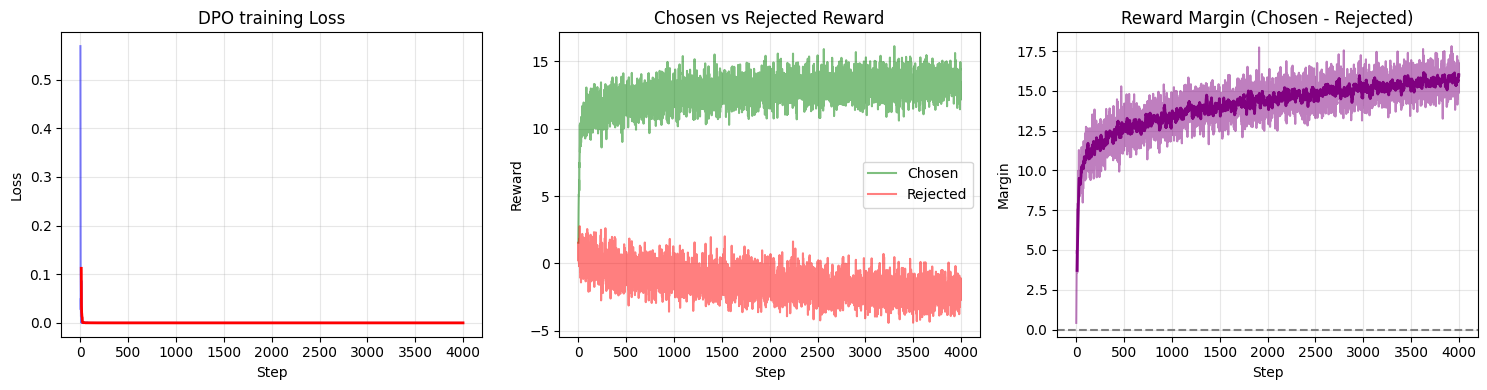


最终Reward边际: 15.5692
(正值表示模型更偏好chosen回答)


In [21]:
# 可视化训练过程
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# DPO Loss
axes[0].plot(history['train_losses'], 'b-', alpha=0.5)
window = 10
if len(history['train_losses']) > window:
    smoothed = np.convolve(history['train_losses'], np.ones(window)/window, mode='valid')
    axes[0].plot(range(window-1, len(history['train_losses'])), smoothed, 'r-', linewidth=2)
axes[0].set_xlabel('Step')
axes[0].set_ylabel('Loss')
axes[0].set_title('DPO training Loss')
axes[0].grid(True, alpha=0.3)

# Reward对比
axes[1].plot(history['chosen_rewards'], 'g-', alpha=0.5, label='Chosen')
axes[1].plot(history['rejected_rewards'], 'r-', alpha=0.5, label='Rejected')
axes[1].set_xlabel('Step')
axes[1].set_ylabel('Reward')
axes[1].set_title('Chosen vs Rejected Reward')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Reward边际
margin = [c - r for c, r in zip(history['chosen_rewards'], history['rejected_rewards'])]
axes[2].plot(margin, 'purple', alpha=0.5)
if len(margin) > window:
    smoothed = np.convolve(margin, np.ones(window)/window, mode='valid')
    axes[2].plot(range(window-1, len(margin)), smoothed, 'purple', linewidth=2)
axes[2].axhline(y=0, color='gray', linestyle='--')
axes[2].set_xlabel('Step')
axes[2].set_ylabel('Margin')
axes[2].set_title('Reward Margin (Chosen - Rejected)')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n最终Reward边际: {margin[-1]:.4f}")
print("(正值表示模型更偏好chosen回答)")

## Part 5: 测试DPO模型

In [22]:
def chat(model, tokenizer, instruction, max_new_tokens=100, temperature=0.7):
    """与模型对话"""
    model.eval()
    
    prompt = ChatMLFormatter.format_prompt_only(instruction)
    input_ids = torch.tensor([tokenizer.encode(prompt, add_bos=True, add_eos=False)]).to(device)
    
    with torch.no_grad():
        output_ids = model.generate(
            input_ids,
            max_new_tokens=max_new_tokens,
            temperature=temperature,
            top_k=50,
            do_sample=True
        )
    
    full_response = tokenizer.decode(output_ids[0].tolist())
    
    if ChatMLFormatter.ASSISTANT_TOKEN in full_response:
        response = full_response.split(ChatMLFormatter.ASSISTANT_TOKEN)[-1]
        if ChatMLFormatter.END_TOKEN in response:
            response = response.split(ChatMLFormatter.END_TOKEN)[0]
    else:
        response = full_response
    
    return response.strip()

In [23]:
# 加载DPO模型
dpo_model = CustomGPT.from_pretrained(
    os.path.join(CHECKPOINT_DIR, "dpo_model")
).to(device)

# 加载SFT模型用于对比
sft_model = CustomGPT.from_pretrained(
    os.path.join(CHECKPOINT_DIR, "sft_model")
).to(device)

print("模型加载完成")

Model loaded from c:\Users\lvbab\Documents\GitHub\LLM-Agent-Core_Concept_Code\models\custom_gpt\dpo_model
Model loaded from c:\Users\lvbab\Documents\GitHub\LLM-Agent-Core_Concept_Code\models\custom_gpt\sft_model
模型加载完成


In [24]:
# SFT vs DPO 对比
test_items = DPO_TEST[:3]

print("SFT模型 vs DPO模型 对比(偏好任务):")
print("=" * 70)

for item in test_items:
    prompt = item["prompt"]
    chosen = item["chosen"]
    rejected = item["rejected"]

    sft_response = chat(sft_model, tokenizer, prompt)
    dpo_response = chat(dpo_model, tokenizer, prompt)

    print(f"\n问题: {prompt}")
    print(f"Chosen: {chosen}")
    print(f"Rejected: {rejected}")

    print(f"\n[SFT模型]:")
    print(f"{sft_response}")

    print(f"\n[DPO模型]:")
    print(f"{dpo_response}")
    print("\n" + "=" * 70)

SFT模型 vs DPO模型 对比(偏好任务):

问题: 分类是做什么的？
Chosen: 要点：① 定义：把样本分到离散类别；② 作用：用于垃圾邮件识别。
Rejected: 分类指把样本分到离散类别，用途是用于垃圾邮件识别。

[SFT模型]:
Embening是将词映射到连续向量。

[DPO模型]:
参数量。


问题: 请解释：Top-k
Chosen: 要点：1) 定义：只从概率最高k个采样 2) 作用：用于限制输出分布。
Rejected: Top-k指只从概率最高k个采样，用途是用于限制输出分布。

[SFT模型]:
Tokenizer把文本切分成模型可处理的token。

[DPO模型]:
参数量。


问题: 什么是强化学习？
Chosen: 要点：① 定义：通过奖励信号学习策略；② 作用：用于决策与控制。
Rejected: 强化学习指通过奖励信号学习策略，用途是用于决策与控制。

[SFT模型]:
强化学习通过奖励信号学习策略。

[DPO模型]:
关注意力让模型可学习权重的数据中学习权重的数。



### 更直观的比较结果可参考Ch10_DPO章节

## 总结

### 本notebook完成的内容

1. **DPO偏好数据**
   - (prompt, chosen, rejected)三元组
   - chosen是人类偏好的回答
   - rejected是不偏好的回答

2. **DPO算法实现**
   - 使用参考模型计算基准概率
   - 优化log ratio差异
   - β参数控制偏离程度

3. **训练监控**
   - DPO Loss
   - Chosen/Rejected Reward
   - Reward边际（正值表示偏好正确）

### DPO vs RLHF

| 方面 | RLHF | DPO |
|------|------|-----|
| 复杂度 | 需要Reward Model + PPO | 直接优化 |
| 稳定性 | PPO难调参 | 更稳定 |
| 计算量 | 大 | 小 |
| 效果 | 成熟 | 接近 |

### 下一步: 评估对比 (05_Evaluation.ipynb)

在下一个notebook中，我们将系统地评估和对比：
- Base模型（预训练后）
- SFT模型
- DPO模型

通过多个维度（困惑度、生成质量、偏好一致性）进行定量和定性分析。